In [ ]:
import os
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download
import scanpy as sc
import pandas as pd
import sys
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
sys.path.append("./MuCST")

# Load Data

https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0

In [ ]:
# device = torch.device("npu:0")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
dir_input = "SEDR_analyses/data/BRCA1/V1_Human_Breast_Cancer_Block_A_Section_1"

In [ ]:
metadata = pd.read_csv("SEDR_analyses/data/BRCA1/metadata.tsv", sep='\t')

In [ ]:
adata = sc.read_10x_h5(f'{dir_input}/filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

spatial=pd.read_csv(f"{dir_input}/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0)

adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]

adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.obs['pred'] = metadata['annot_type'].values

adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

c:\academic\anoconda_new\envs\patho\lib\site-packages\anndata\_core\anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\academic\anoconda_new\envs\patho\lib\site-packages\anndata\_core\anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
adata

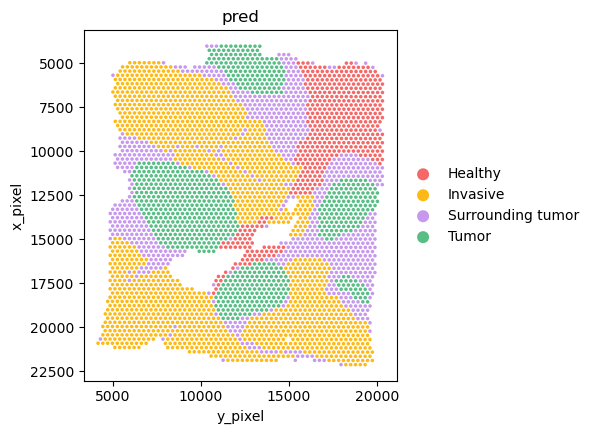

In [6]:
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

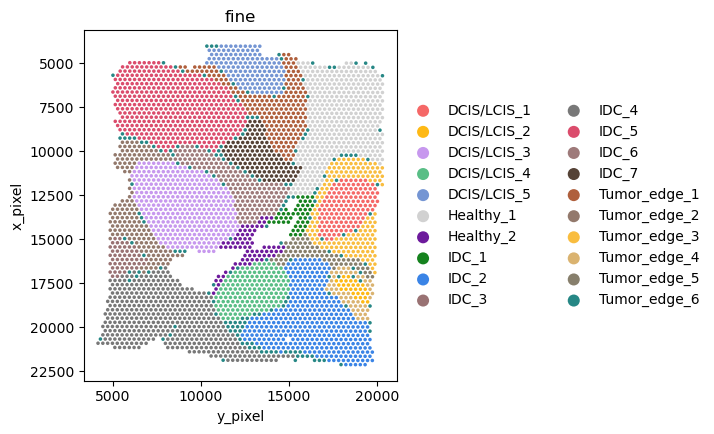

In [7]:
adata.obs['fine'] = metadata['fine_annot_type'].values
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="fine"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

# Load Model

In [12]:
local_dir = "./uni/UNI/assets/ckpts/uni2-h/"
# os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
# hf_hub_download("MahmoodLab/UNI2-h", filename="pytorch_model.bin", local_dir=local_dir)
timm_kwargs = {
            'model_name': 'vit_giant_patch14_224',
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
model = timm.create_model(
    pretrained=False, **timm_kwargs
)
model.load_state_dict(torch.load("./uni/UNI/assets/ckpts/uni2-h/pytorch_model.bin", map_location=device), strict=True)
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
model.eval();
model.to(device);

In [13]:
import sys 
sys.path.append("./scFoundation/model/") # path to this folder
from load import *
ckpt_path = "./scFoundation/model/models/models.ckpt"
pretrainmodel,pretrainconfig = load_model_frommmf(ckpt_path)

{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decoder_add_zero': True, 'mae_encoder_max_seq_len': 15000, 'isPlanA': False, 'ma

In [54]:
adata.obs

,x1,x2,x3,x4,x5,pred,x_array,y_array,x_pixel,y_pixel,fine
AAACAAGTATCTCCCA-1,1,50,102,15937,17428,Surrounding tumor,50,102,15937,17428,Tumor_edge_5
AAACACCAATAACTGC-1,1,59,19,18054,6092,Invasive,59,19,18054,6092,IDC_4
AAACAGAGCGACTCCT-1,1,14,94,7383,16351,Healthy,14,94,7383,16351,Healthy_1
AAACAGGGTCTATATT-1,1,47,13,15202,5278,Invasive,47,13,15202,5278,IDC_3
AAACAGTGTTCCTGGG-1,1,73,43,21386,9363,Invasive,73,43,21386,9363,IDC_4
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,11417,14023,Invasive,31,77,11417,14023,IDC_7
TTGTTTCACATCCAGG-1,1,58,42,17822,9233,Invasive,58,42,17822,9233,IDC_4
TTGTTTCATTAGTCTA-1,1,60,30,18294,7593,Invasive,60,30,18294,7593,IDC_4
TTGTTTCCATACAACT-1,1,45,27,14730,7190,Surrounding tumor,45,27,14730,7190,Tumor_edge_2


In [20]:
image = Image.open("D:/hw/RuiPath/10xBRC/4176-20901-224.png")
image = transform(image).unsqueeze(dim=0) # Image (torch.Tensor) with shape [1, 3, 224, 224] following image resizing and normalization (ImageNet parameters)
with torch.inference_mode():
 feature_emb = model(image.to(device))

In [50]:
os.listdir(directory_path)

['10046-21149-224.png',
 '10047-20199-224.png',
 '10047-20674-224.png',
 '10048-19724-224.png',
 '10049-19249-224.png',
 '10050-18774-224.png',
 '10051-18299-224.png',
 '10056-15448-224.png',
 '10057-14973-224.png',
 '10058-14498-224.png',
 '10059-14023-224.png',
 '10060-13073-224.png',
 '10060-13548-224.png',
 '10061-12598-224.png',
 '10062-12122-224.png',
 '10063-11647-224.png',
 '10064-11172-224.png',
 '10065-10697-224.png',
 '10066-10222-224.png',
 '10067-9272-224.png',
 '10067-9747-224.png',
 '10068-8797-224.png',
 '10069-8322-224.png',
 '10070-7847-224.png',
 '10071-7371-224.png',
 '10072-6896-224.png',
 '10073-6421-224.png',
 '10074-5471-224.png',
 '10074-5946-224.png',
 '10182-21387-224.png',
 '10183-20912-224.png',
 '10184-19962-224.png',
 '10184-20437-224.png',
 '10185-19487-224.png',
 '10186-19012-224.png',
 '10187-18537-224.png',
 '10188-18062-224.png',
 '10192-15686-224.png',
 '10193-15211-224.png',
 '10194-14736-224.png',
 '10195-14261-224.png',
 '10196-13786-224.png',
 '

In [62]:
img_encodings = {}

# Process all PNG files
directory_path = 'D:/hw/RuiPath/10xBRC/'
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
        
    try:
        # Load and preprocess image
        image = Image.open(file_path)
        input_tensor = transform(image).unsqueeze(0).to(device) 
        
        # Get encoding
        with torch.no_grad():
            img_encoding = model(input_tensor)
            img_encoding = img_encoding.squeeze()
        
        img_encodings[filename.rstrip('.png')] = img_encoding.detach().cpu().numpy()
        print(f"Encoded {filename}: shape {img_encoding.shape}")
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
    print(str(len(img_encodings)/len(os.listdir(directory_path))))
    

Encoded AAACAAGTATCTCCCA-1.png: shape torch.Size([1536])
0.0002632964718272775
Encoded AAACACCAATAACTGC-1.png: shape torch.Size([1536])
0.000526592943654555
Encoded AAACAGAGCGACTCCT-1.png: shape torch.Size([1536])
0.0007898894154818325
Encoded AAACAGGGTCTATATT-1.png: shape torch.Size([1536])
0.00105318588730911
Encoded AAACAGTGTTCCTGGG-1.png: shape torch.Size([1536])
0.0013164823591363876
Encoded AAACATTTCCCGGATT-1.png: shape torch.Size([1536])
0.001579778830963665
Encoded AAACCCGAACGAAATC-1.png: shape torch.Size([1536])
0.0018430753027909425
Encoded AAACCGGGTAGGTACC-1.png: shape torch.Size([1536])
0.00210637177461822
Encoded AAACCTAAGCAGCCGG-1.png: shape torch.Size([1536])
0.002369668246445498
Encoded AAACCTCATGAAGTTG-1.png: shape torch.Size([1536])
0.0026329647182727752
Encoded AAACGAAGAACATACC-1.png: shape torch.Size([1536])
0.0028962611901000527
Encoded AAACGAGACGGTTGAT-1.png: shape torch.Size([1536])
0.00315955766192733
Encoded AAACGCCCGAGATCGG-1.png: shape torch.Size([1536])
0.00

In [63]:
img_encodings_df = pd.DataFrame.from_dict(img_encodings, orient='index')

In [64]:
img_encodings_df

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
AAACAAGTATCTCCCA-1,0.263513,0.114114,-0.055175,-0.519855,-0.479384,-0.395428,0.319304,0.590935,-0.091658,-0.255318,...,-0.182172,-0.144553,-0.046457,-0.029173,0.180332,0.046329,0.443193,-0.596419,0.166847,0.050646
AAACACCAATAACTGC-1,0.208668,-0.108435,-0.193329,-0.658872,-0.008430,-0.526946,0.121950,-0.520637,-0.153163,0.370475,...,0.183054,0.151499,-0.242610,0.229448,0.267911,-0.599831,0.227436,-0.090838,0.265400,-0.235285
AAACAGAGCGACTCCT-1,0.523462,-0.057334,-0.466537,-0.435067,-0.353434,-0.447215,0.135279,0.287799,0.032889,0.137714,...,0.175589,-0.194680,-0.095438,-0.049956,0.197998,-0.179823,0.083784,-0.084050,-0.308483,-0.173639
AAACAGGGTCTATATT-1,-0.098451,0.316236,-0.326745,-0.751564,-0.291553,-0.594713,0.121425,0.077940,0.159027,-0.524736,...,0.054897,-0.388398,0.173113,0.038537,0.891889,-0.716535,0.304673,0.220957,-0.709161,-0.453286
AAACAGTGTTCCTGGG-1,0.305497,0.100917,-0.252728,-0.769222,-0.123026,-0.354405,-0.062741,-0.108398,-0.106907,0.125434,...,-0.072469,-0.113900,0.103848,0.362636,0.139870,-0.242814,0.243436,-0.297323,-0.457104,-0.240569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,-0.186064,-0.640825,-0.239198,-0.532083,-0.193130,-0.614974,-0.479691,0.099001,-0.471376,0.406605,...,-0.304493,0.063443,0.232108,-0.500084,0.061116,-0.425181,-0.039008,-0.209459,0.116403,0.572136
TTGTTTCACATCCAGG-1,0.285964,0.354827,-0.119693,-0.420891,-0.220591,-0.421415,0.127373,-0.062190,-0.064511,0.030072,...,0.595732,-0.256235,0.078362,-0.629604,0.134494,-0.582057,0.164601,-0.062976,0.137409,-0.386779
TTGTTTCATTAGTCTA-1,-0.375839,0.173615,0.085967,-0.586849,-0.385878,-1.000813,0.228744,-0.299410,-0.211508,0.457751,...,-0.097557,-0.726073,0.042785,-0.314531,0.162738,-0.203604,0.473780,-0.197742,-0.358753,-0.308870
TTGTTTCCATACAACT-1,0.100114,0.261976,-0.289193,-0.567749,-0.319540,-0.319157,0.308451,0.083961,0.052951,-0.251498,...,0.327736,-0.239880,-0.186498,0.262859,0.444530,-0.488410,-0.110947,0.046456,-0.263658,0.380211


In [65]:
img_encodings_df.to_csv('./10x_BRC/img_encodings.csv')

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(img_encodings_df)

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y_pred, metadata['annot_type'].values)
print(f"Adjusted Rand Index: {ari:.4f}")

In [ ]:
feature_emb

In [ ]:

adata.obs_names

In [ ]:
adata.var

In [22]:
gene_list_df = pd.read_csv('./scFoundation/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])

In [23]:
gexpr_feature = adata.X.toarray()
idx = adata.obs_names.tolist()
col = adata.var['genename'].tolist()
gexpr_feature = pd.DataFrame(gexpr_feature,index=idx,columns=col)

In [24]:
def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns,var

In [25]:
gexpr_feature, _, _ = main_gene_selection(gexpr_feature,gene_list)

In [26]:
gexpr_feature

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
AAACAAGTATCTCCCA-1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
AAACACCAATAACTGC-1,5.0,0.0,19.0,0.0,0.0,0.0,0.0,9.0,3.0,0.0,...,1.0,3.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
AAACAGGGTCTATATT-1,2.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACAGTGTTCCTGGG-1,4.0,0.0,11.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
TTGTTTCACATCCAGG-1,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0
TTGTTTCATTAGTCTA-1,2.0,0.0,15.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0,0.0
TTGTTTCCATACAACT-1,2.0,0.0,13.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
adata_tmp = sc.AnnData(gexpr_feature)
sc.pp.normalize_total(adata_tmp)
sc.pp.log1p(adata_tmp)
gexpr_feature_normalized = pd.DataFrame(adata_tmp.X,index=adata_tmp.obs_names,columns=adata_tmp.var_names)

In [28]:
sys.path.append("./scFoundation/model/") 
from load import *

In [29]:
tgthighres = 'h5'
geneexpemb=[]

for i in tqdm(range(gexpr_feature.shape[0])):
    with torch.no_grad():
        tmpdata = (gexpr_feature.iloc[i,:]).tolist()
        totalcount = gexpr_feature.iloc[i,:].sum()
        pretrain_gene_x = torch.tensor(tmpdata+[np.log10(totalcount)+float(tgthighres[1:]),np.log10(totalcount)]).unsqueeze(0).cuda()
        value_labels = pretrain_gene_x > 0
        data_gene_ids = torch.arange(19266, device=pretrain_gene_x.device).repeat(pretrain_gene_x.shape[0], 1)
        x, x_padding = gatherData(pretrain_gene_x, value_labels, pretrainconfig['pad_token_id'])
        position_gene_ids, _ = gatherData(data_gene_ids, value_labels, pretrainconfig['pad_token_id'])
        x = pretrainmodel.token_emb(torch.unsqueeze(x, 2).float(), output_weight = 0)
        position_emb = pretrainmodel.pos_emb(position_gene_ids)
        x += position_emb
        geneemb = pretrainmodel.encoder(x,x_padding)

        geneemb1 = geneemb[:,-1,:]
        geneemb2 = geneemb[:,-2,:]
        geneemb3, _ = torch.max(geneemb[:,:-2,:], dim=1)
        geneemb4 = torch.mean(geneemb[:,:-2,:], dim=1)
        geneembmerge = torch.concat([geneemb1,geneemb2,geneemb3,geneemb4],axis=1)
        geneexpemb.append(geneembmerge.detach().cpu().numpy())

100%|██████████| 3798/3798 [23:06<00:00,  2.74it/s]


In [32]:
gexpr_feature

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
AAACAAGTATCTCCCA-1,0.000000,0.0,2.113555,0.0,0.0,0.00000,0.0,1.534458,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.534458,0.000000,0.0
AAACACCAATAACTGC-1,1.059703,0.0,2.099851,0.0,0.0,0.00000,0.0,1.480223,0.756736,0.0,...,0.319982,0.756736,0.000000,0.562016,0.319982,0.0,0.562016,0.319982,0.000000,0.0
AAACAGAGCGACTCCT-1,0.000000,0.0,2.400216,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.400216,1.793887,0.0
AAACAGGGTCTATATT-1,1.163452,0.0,2.389161,0.0,0.0,0.00000,0.0,0.742167,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.742167,0.000000,0.0
AAACAGTGTTCCTGGG-1,0.950390,0.0,1.679612,0.0,0.0,0.58409,0.0,0.950390,0.000000,0.0,...,0.000000,0.584090,0.000000,0.584090,0.000000,0.0,0.000000,0.584090,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.727486,0.0,1.663828,0.0,0.0,0.00000,0.0,1.437370,0.000000,0.0,...,0.000000,1.144140,0.000000,0.000000,0.000000,0.0,0.000000,1.663828,0.000000,0.0
TTGTTTCACATCCAGG-1,1.373022,0.0,1.930727,0.0,0.0,0.00000,0.0,1.373022,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.684318,1.595274,0.000000,0.0
TTGTTTCATTAGTCTA-1,0.803445,0.0,2.327196,0.0,0.0,0.00000,0.0,1.047260,1.243129,0.0,...,0.000000,0.480332,0.000000,0.000000,0.480332,0.0,0.000000,1.243129,1.047260,0.0
TTGTTTCCATACAACT-1,1.168530,0.0,2.735159,0.0,0.0,0.00000,0.0,1.168530,0.746039,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.746039,0.000000,0.0


In [37]:
geneexpemb[0].flatten()

array([ 1.3641899,  1.1007543, -0.1512991, ..., -0.5203806, -1.4841105,
       -1.1964444], shape=(3072,), dtype=float32)

In [38]:
geneexpemb_df = pd.DataFrame([row.flatten() for row in geneexpemb], index=gexpr_feature.index)

In [47]:
geneexpemb_df.to_csv('./10x_BRC/gene_encodings.csv')

In [48]:
geneexpemb_df

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
AAACAAGTATCTCCCA-1,1.364190,1.100754,-0.151299,-0.184028,-0.965182,0.430317,-0.375085,-1.297632,1.002105,-0.374131,...,1.260858,0.851764,0.016384,0.526462,-0.135920,-1.240861,-0.496185,-0.520381,-1.484110,-1.196444
AAACACCAATAACTGC-1,0.598154,1.004739,-0.828564,0.081316,-1.015369,1.557337,0.225602,-0.451988,0.495269,0.801878,...,1.045684,0.795704,0.540161,1.487413,0.361228,-2.011108,-0.953382,-0.083770,-0.881987,-0.246633
AAACAGAGCGACTCCT-1,0.341538,1.728669,-0.430909,0.118753,0.079210,0.911549,-0.136607,-0.903346,0.795774,-0.281015,...,1.055935,0.818963,0.185800,-0.387702,0.020804,-0.644194,0.827760,-0.196136,-1.911432,-1.500961
AAACAGGGTCTATATT-1,1.015676,1.703912,0.008401,-0.903943,-0.556378,-0.248320,-0.544537,-0.557668,0.914861,-0.898290,...,1.225047,1.306961,0.001774,1.031584,0.443962,-2.084562,-0.629209,-0.317600,-1.131760,-0.690115
AAACAGTGTTCCTGGG-1,0.179086,0.946632,-0.509214,-0.213362,-0.544036,1.370378,0.215279,0.524666,0.711765,0.397110,...,1.163174,0.762808,0.393608,1.331505,0.362723,-2.038579,-1.208730,-0.413548,-0.617336,-0.532456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.391017,0.718798,-0.975845,-0.110054,-0.573662,0.670045,0.089908,0.114144,-0.092393,0.801153,...,1.151857,1.024168,0.431327,0.914135,0.066237,-1.263756,-0.529771,0.031833,-1.507774,-0.682684
TTGTTTCACATCCAGG-1,1.157276,1.362824,-0.791583,0.087789,-0.519496,1.197862,0.377275,-0.968025,0.761971,0.138335,...,1.214325,1.128670,0.291667,1.100826,0.050286,-1.750462,-0.646072,-0.089954,-1.341767,-0.955451
TTGTTTCATTAGTCTA-1,0.721430,0.805179,-0.948118,-0.209613,-0.814296,1.412955,0.543125,-0.151393,-0.025116,0.295794,...,1.166410,0.941073,0.248000,1.132362,0.168509,-1.732379,-0.633953,-0.055039,-1.038847,-0.490743
TTGTTTCCATACAACT-1,0.924816,0.711268,-0.122627,-0.260469,-0.696872,1.426805,-0.048794,0.407913,0.356545,-0.336275,...,1.065941,0.941334,0.391638,0.784473,0.043626,-1.518588,-0.963682,-0.345252,-1.055999,-0.508329


In [49]:
img_encodings_df

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
10046-21149-224.png,-0.344493,0.117953,0.207682,-0.631434,0.031771,-0.478766,0.106141,-0.296607,-0.441259,0.773394,...,0.161226,-0.173759,-0.357055,0.163448,0.425451,-0.414438,0.726356,-0.315991,-0.180180,-0.539338
10047-20199-224.png,0.097950,-0.000259,0.087058,-0.553259,-0.077626,-0.462570,0.130255,-0.268799,-0.419341,0.384089,...,0.169520,-0.207025,-0.086623,-0.086179,0.383532,-0.395468,0.247386,-0.085167,-0.344242,-0.454297
10047-20674-224.png,-0.169228,-0.018710,-0.081466,-0.750741,-0.146762,-0.322260,0.014434,-0.253036,-0.347934,0.351282,...,0.146978,-0.041668,-0.102196,0.129118,0.384086,-0.385246,0.584971,-0.339074,-0.433040,-0.325892
10048-19724-224.png,-0.128122,0.352391,-0.181850,-0.736670,0.067829,-0.381280,0.261583,-0.007981,-0.811176,0.142747,...,0.301587,-0.321509,0.003233,0.623172,0.956723,-0.176884,0.543073,0.023169,-0.266018,-0.104259
10049-19249-224.png,-0.128597,-0.206699,0.102707,-0.592709,0.003916,-0.528254,0.038864,-0.364695,0.038395,0.426226,...,-0.294306,-0.020088,-0.141140,0.152962,0.263139,-0.526545,0.507198,-0.121846,-0.213930,-0.021865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935-7134-224.png,0.273487,0.160548,-0.114021,-0.757152,-0.057125,-0.436659,-0.084189,-0.592609,-0.024905,0.034229,...,-0.277697,-0.330506,0.041354,0.182886,0.012992,-0.744116,0.121895,-0.069669,-0.225608,0.261753
9936-6659-224.png,0.316877,0.430454,0.123244,-0.732377,-0.183662,-0.260898,0.156830,-0.286780,-0.109867,-0.634788,...,0.221853,0.043943,-0.462508,0.120135,0.495568,-0.345579,-0.064999,0.168575,-0.046285,-0.254632
9937-5708-224.png,0.409650,0.041971,-0.135599,-0.728576,-0.073073,-0.095912,0.108934,-0.264226,-0.298817,-0.245189,...,-0.101581,0.054597,0.121256,0.406438,0.573566,-0.392563,0.133873,-0.204264,-0.133476,-0.274889
9937-6183-224.png,0.176283,0.381091,0.268274,-0.627196,-0.121651,-0.001352,0.080368,-0.233367,-0.197250,-0.203090,...,-0.240849,-0.397481,-0.079501,0.129493,0.221630,-0.583253,-0.064199,0.223969,-0.057659,-0.099995


In [69]:
all_embeds = img_encodings_df.join(geneexpemb_df, lsuffix='_img', rsuffix='_gene')

In [72]:
all_embeds

,0_img,1_img,2_img,3_img,4_img,5_img,6_img,7_img,8_img,9_img,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
AAACAAGTATCTCCCA-1,0.263513,0.114114,-0.055175,-0.519855,-0.479384,-0.395428,0.319304,0.590935,-0.091658,-0.255318,...,1.260858,0.851764,0.016384,0.526462,-0.135920,-1.240861,-0.496185,-0.520381,-1.484110,-1.196444
AAACACCAATAACTGC-1,0.208668,-0.108435,-0.193329,-0.658872,-0.008430,-0.526946,0.121950,-0.520637,-0.153163,0.370475,...,1.045684,0.795704,0.540161,1.487413,0.361228,-2.011108,-0.953382,-0.083770,-0.881987,-0.246633
AAACAGAGCGACTCCT-1,0.523462,-0.057334,-0.466537,-0.435067,-0.353434,-0.447215,0.135279,0.287799,0.032889,0.137714,...,1.055935,0.818963,0.185800,-0.387702,0.020804,-0.644194,0.827760,-0.196136,-1.911432,-1.500961
AAACAGGGTCTATATT-1,-0.098451,0.316236,-0.326745,-0.751564,-0.291553,-0.594713,0.121425,0.077940,0.159027,-0.524736,...,1.225047,1.306961,0.001774,1.031584,0.443962,-2.084562,-0.629209,-0.317600,-1.131760,-0.690115
AAACAGTGTTCCTGGG-1,0.305497,0.100917,-0.252728,-0.769222,-0.123026,-0.354405,-0.062741,-0.108398,-0.106907,0.125434,...,1.163174,0.762808,0.393608,1.331505,0.362723,-2.038579,-1.208730,-0.413548,-0.617336,-0.532456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,-0.186064,-0.640825,-0.239198,-0.532083,-0.193130,-0.614974,-0.479691,0.099001,-0.471376,0.406605,...,1.151857,1.024168,0.431327,0.914135,0.066237,-1.263756,-0.529771,0.031833,-1.507774,-0.682684
TTGTTTCACATCCAGG-1,0.285964,0.354827,-0.119693,-0.420891,-0.220591,-0.421415,0.127373,-0.062190,-0.064511,0.030072,...,1.214325,1.128670,0.291667,1.100826,0.050286,-1.750462,-0.646072,-0.089954,-1.341767,-0.955451
TTGTTTCATTAGTCTA-1,-0.375839,0.173615,0.085967,-0.586849,-0.385878,-1.000813,0.228744,-0.299410,-0.211508,0.457751,...,1.166410,0.941073,0.248000,1.132362,0.168509,-1.732379,-0.633953,-0.055039,-1.038847,-0.490743
TTGTTTCCATACAACT-1,0.100114,0.261976,-0.289193,-0.567749,-0.319540,-0.319157,0.308451,0.083961,0.052951,-0.251498,...,1.065941,0.941334,0.391638,0.784473,0.043626,-1.518588,-0.963682,-0.345252,-1.055999,-0.508329


In [103]:
fake_adata = sc.AnnData(all_embeds.values)
fake_adata.obs = adata.obs.loc[all_embeds.index].copy()
fake_adata.obs_names = all_embeds.index
sc.pp.neighbors(fake_adata, n_neighbors=4, n_pcs=40)

# 8. Perform Clustering
# Leiden clustering
sc.tl.leiden(fake_adata, resolution=0.6)

c:\academic\anoconda_new\envs\patho\lib\site-packages\scanpy\neighbors\__init__.py:586: UserWarning: You’re trying to run this on 4608 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


In [105]:
fake_adata.obs

,x1,x2,x3,x4,x5,pred,x_array,y_array,x_pixel,y_pixel,fine,leiden
AAACAAGTATCTCCCA-1,1,50,102,15937,17428,Surrounding tumor,50,102,15937,17428,Tumor_edge_5,5
AAACACCAATAACTGC-1,1,59,19,18054,6092,Invasive,59,19,18054,6092,IDC_4,0
AAACAGAGCGACTCCT-1,1,14,94,7383,16351,Healthy,14,94,7383,16351,Healthy_1,7
AAACAGGGTCTATATT-1,1,47,13,15202,5278,Invasive,47,13,15202,5278,IDC_3,8
AAACAGTGTTCCTGGG-1,1,73,43,21386,9363,Invasive,73,43,21386,9363,IDC_4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,11417,14023,Invasive,31,77,11417,14023,IDC_7,6
TTGTTTCACATCCAGG-1,1,58,42,17822,9233,Invasive,58,42,17822,9233,IDC_4,0
TTGTTTCATTAGTCTA-1,1,60,30,18294,7593,Invasive,60,30,18294,7593,IDC_4,0
TTGTTTCCATACAACT-1,1,45,27,14730,7190,Surrounding tumor,45,27,14730,7190,Tumor_edge_2,2


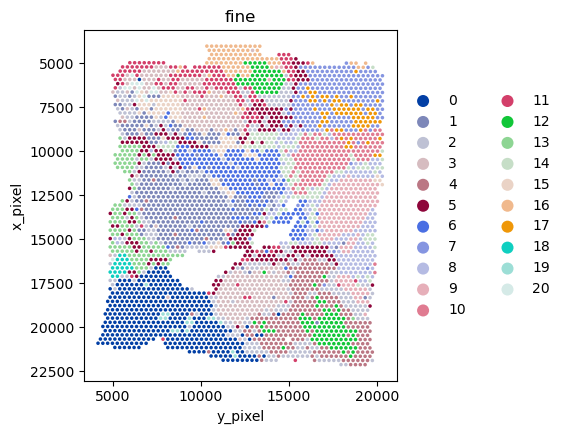

In [106]:
ax=sc.pl.scatter(fake_adata,alpha=1,x="y_pixel",y="x_pixel",color='leiden',title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

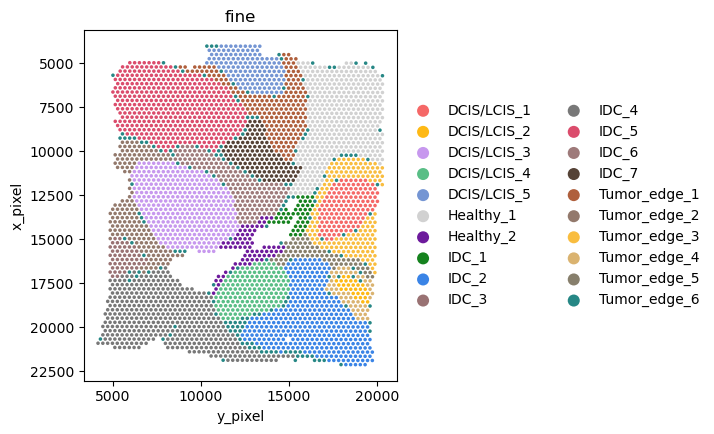

In [94]:
adata.obs['fine'] = metadata['fine_annot_type'].values
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="fine"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

In [108]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(fake_adata.obs['leiden'], fake_adata.obs['fine'])
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.4443
